In [1]:
import sys
#sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/LyA/commands')
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/Data loader')
sys.path.append('/eos/user/l/lkoller/SWAN_projects/data analysis 2024/commands')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from PIL import Image
from readTrc_4CH import Trc
from time import time
from tqdm import tqdm
import os
import scipy.signal as sci
from cluster_finder import cfinder
pd.set_option("display.max_columns",150)

In [9]:
datafile = pd.read_csv('/eos/experiment/gbar/datasummary/datafile24.txt', delimiter = '\t', low_memory = False)
data = datafile[[True if val in [609] else False for val in datafile.run]]
dfm = data[data.run_mode == 1] #mixing
#dfm = dfm[dfm.Positron_Waveform != 'None']
dfb = data[data.run_mode == 2] #background

In [10]:
dfmle = dfm[dfm.NE50_I < 7]
dfmhe = dfm[dfm.NE50_I > 7]

fmle = list(dfmle.Positron_Waveform)
fmhe = list(dfmhe.Positron_Waveform)

fbe = list(dfb[dfb.Positron_Waveform != 'None'].Positron_Waveform)

In [42]:
cont = [Trc().open(fbe[0])[0][0], [(val+bal)/2 for val,bal in zip(Trc().open(fbe[0])[1][0], Trc().open(fbe[2])[1][0])]]

In [61]:
(0.8775-0.84184)/0.0051

6.99215686274508

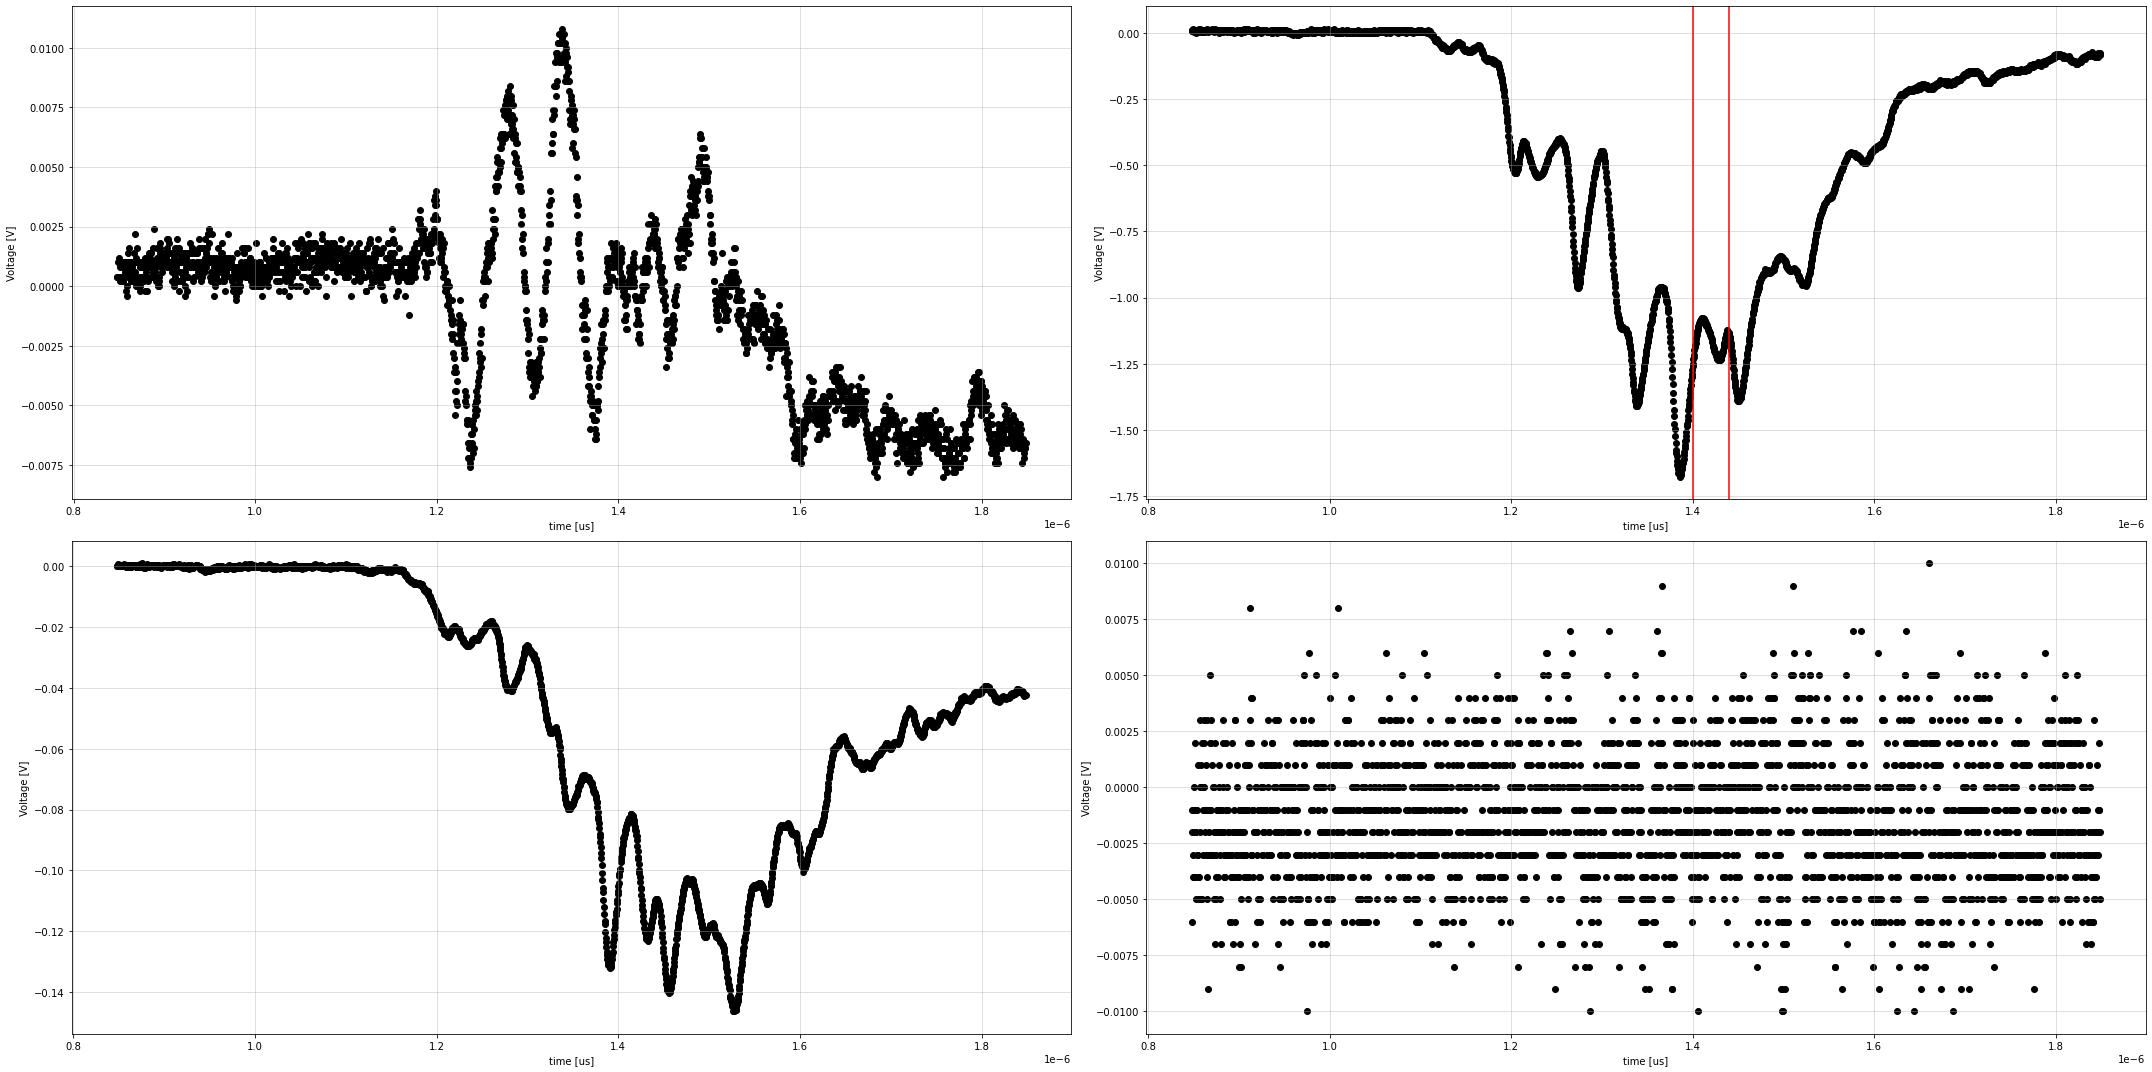

In [14]:
pos = 178

#data = Trc().open(fbe[pos])
data = Trc().open(fmhe[pos])

cont_data = Trc().open(fmhe[2])

fig = plt.figure(layout = 'tight', figsize = (30,15))
gs = GridSpec(2, 2, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

p1 = sci.find_peaks(data[1][0]+0.005, height = 0, distance = 20, prominence = 0.009)
p11 = sci.find_peaks(-data[1][0], height = 0, distance = 20, prominence = 0.009)
p2 = sci.find_peaks(-data[1][1], distance = 20, height = 0, prominence = 0.15)
p = [[data[0][0][np.append(p1[0], p11[0])], data[0][1][p2[0]]], 
      [np.append(p1[1]['peak_heights']-0.005, -p11[1]['peak_heights']), -p2[1]['peak_heights']]]

for i, ax in enumerate(fig.axes):
    ax.scatter(data[0][i], data[1][i], c = 'k')
    #ax.scatter(cont_data[0][i], cont_data[1][i], s = 3, c = 'b')
    ax.grid(alpha = 0.5)
    ax.set_xlabel(xlabel = 'time [us]')
    ax.set_ylabel(ylabel = 'Voltage [V]')
    
#ax1.scatter(p[0][0], p[1][0], c = 'r', s = 10)
#ax1.scatter(cont[0], cont[1])
#ax1.scatter(cont_data[0][0][1350:1450], cont_data[1][0][1350:1450]*min(data[1][0][1350:1450])/min(cont_data[1][0][1350:1450]))
#ax1.axvline(data[0][0][1350], c = 'r')
#ax1.axvline(data[0][0][1450], c = 'r')
#ax1.set_xlim(data[0][0][1300], data[0][0][2000])

#ax2.scatter(p[0][1], p[1][1], c = 'r')
ax2.axvline(data[0][1][1380], c = 'r')
ax2.axvline(data[0][1][1480], c = 'r')
#ax2.set_xlim(data[0][0][1300], data[0][0][2000])

#ax4.axvline(data[0][3][1200], c = 'r')
#ax4.axvline(data[0][3][1800], c = 'r')

In [13]:
#probably better method
#look at maximum and minimum voltages in channel 4 of the positron waveform file
#if there are more than 10 voltages with absolute value above 0.01 V

finv = []

st = time()

for i in (range(len(fmhe))):
    if fmhe[i] == 'None': continue
    temp_data = Trc().open(fmhe[i])
    if len([1 for val in temp_data[1][3][1200:1800] if abs(val) > 0.01]) < 10:
        print(i, ',', len([1 for val in temp_data[1][3][1200:1800] if abs(val) > 0.01]))
        finv += [fmhe[i]]

print('\n', len(finv), ',', time()-st)

178 , 3
179 , 1
180 , 0
181 , 1
182 , 0
183 , 1
184 , 0
185 , 0
186 , 0
187 , 0
188 , 1
189 , 2
190 , 0
191 , 1
192 , 2
193 , 0
194 , 0
195 , 0
196 , 0
197 , 0
198 , 0
199 , 1
210 , 0

 23 , 1.844895839691162


In [35]:
finv = []

st = time()

for i in (range(len(fmhe))):
    temp_data = Trc().open(fmhe[i])
    #temp_pos = np.argmin([abs(1.4216e-6-val) for val in temp_data[0][1]])
    temp_peaks = sci.find_peaks(-temp_data[1][1][1380:1480], height = 0, distance = 20, prominence = 0.15)
    #if min(abs(1.4256e-6-temp_data[0][1][temp_peaks[0]])) > 1.5e-8:
    if len(temp_peaks[0]) == 0:
        #print(i, min(abs(1.4256e-6-temp_data[0][1][temp_peaks[0]])), temp_peaks[0], '\n')
        print(i)
        finv += [fmhe[i]]

print('\n', len(finv), ',', time()-st)

6
35

 2 , 0.10313987731933594


In [13]:
finv = []

for i in (range(len(fmhe))):
    temp_data = Trc().open(fmhe[i])
    voltage = temp_data[1][0][1350:1450]
    control = Trc().open(fmhe[2])[1][0][1350:1450]
    control = control*min(voltage)/min(control)
    diff = sum([(val-bal)**2 for val,bal in zip(control,voltage)])/abs(np.average(voltage)-min(voltage))
    #print(i, diff)
    if diff > 0.1:
        print(i, diff, np.std(control), '\n')
        finv += [fmhe[i]]

9 0.13457029635194132 0.008835084668514792 

45 0.18594253440623815 0.007748803766648219 



In [51]:
wfm = list(dfm.Waveform_12bit)
wfb = list(dfb.Waveform_12bit)

In [52]:
len(wfm)

53

In [10]:
dfm.Positron_Waveform.iloc[169], dfm.Waveform_12bit.iloc[169]

('/eos/experiment/gbar/pgunpc/data/24_07_06/24_07_06posi/POS1234.1720299405.694.trc',
 '/eos/experiment/gbar/pgunpc/data/24_07_06/WF1234.1720299405.694.trc')

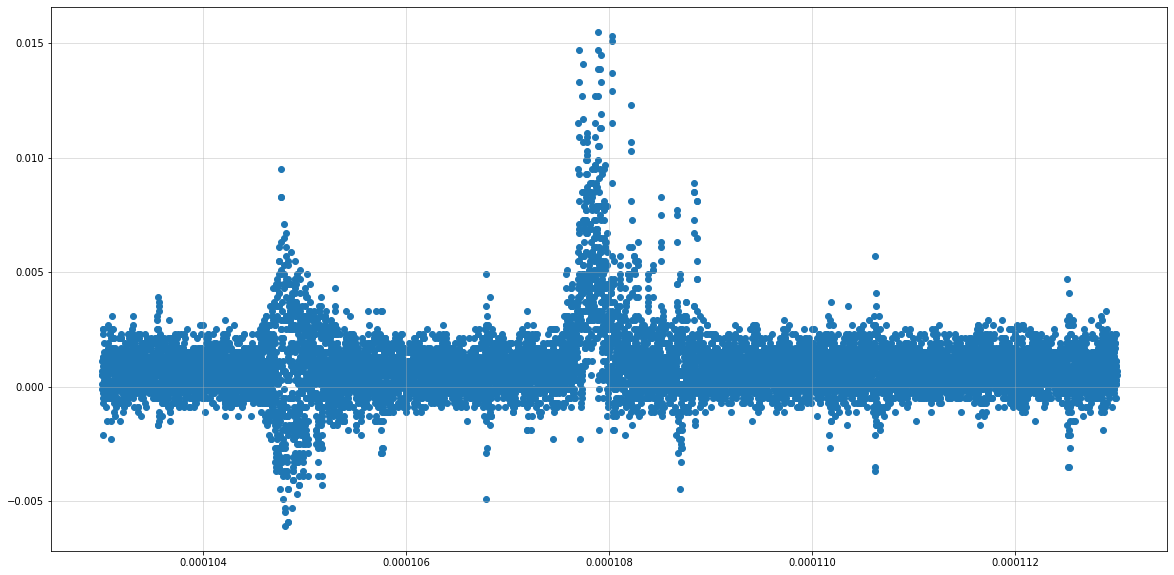

In [55]:
dat = Trc().open(wfm[45])

plt.figure(figsize = (20,10))
plt.grid(alpha = 0.5)
plt.scatter(dat[0][2], dat[1][2])

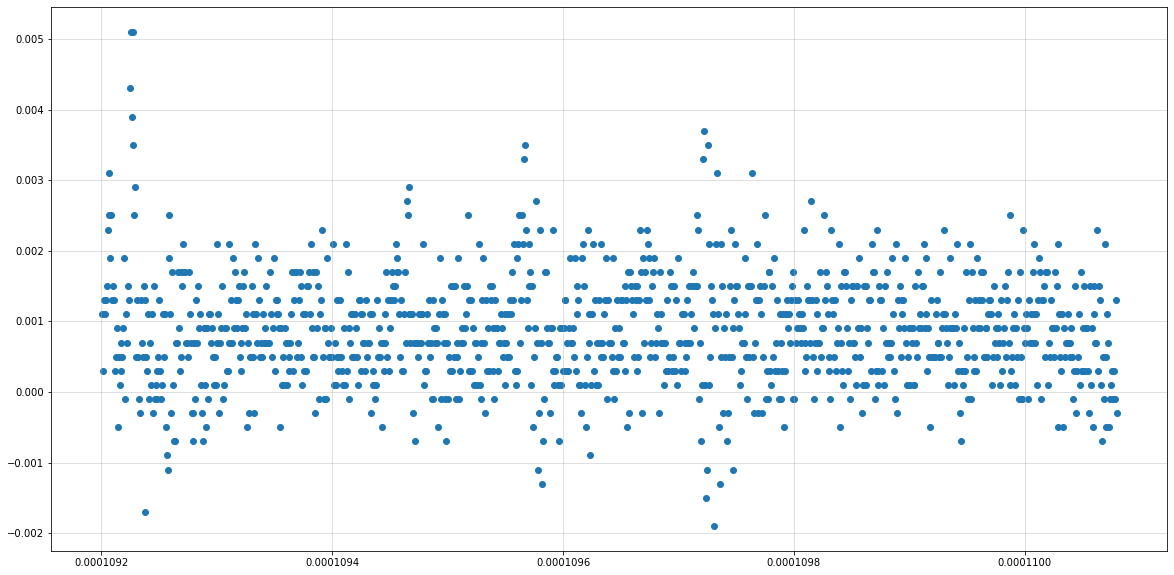

In [16]:
dat = Trc().open(dfm.Waveform_12bit.iloc[169])

plt.figure(figsize = (20,10))
plt.grid(alpha = 0.5)
plt.scatter(dat[0][2][7750:8850], dat[1][2][7750:8850])

873.3439681672519 22.3263271432838


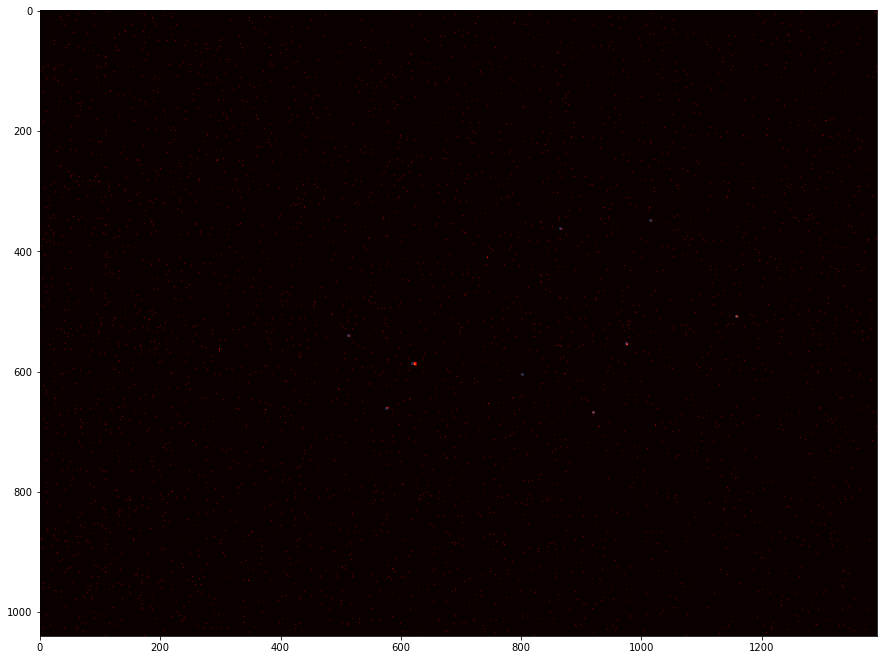

In [20]:
pos = 169

curr_df = cfinder(dfm.MCP5.iloc[pos], min_size = 3)

fig = plt.figure(figsize = (15,15))
arr = np.array(Image.open(dfm.MCP5.iloc[pos]))
thresh = np.average(arr) + 3*np.std(arr)
print(thresh, np.std(arr))
arr[arr < thresh] = 0
arr[arr > 2000] = 2000
#arr = [[(val-thresh)/10+10 if val > 0 else val for val in bal] for bal in arr]
plt.imshow(arr, cmap = 'hot')
plt.scatter(curr_df.ypos, curr_df.xpos, s = 5, alpha = 0.3)

In [21]:
curr_df

,xpos,ypos,size,sum
0,348,1015,5,4540
1,362,865,4,3600
2,507,1157,12,11204
3,539,512,7,6328
4,553,974,12,11060
5,585,619,25,23580
6,604,801,3,2708
7,660,575,8,7272
8,667,919,9,8204


In [148]:
data[0][1][1363], data[0][1][1473], data[0][1][1525], abs(1.4216e-6-data[0][1][1473])

(1.3932841193458558e-06,
 1.4372841199333188e-06,
 1.4580841202110286e-06,
 1.5684119933318716e-08)

In [44]:
p2[1]

{'peak_heights': array([0.74999999, 1.012     , 1.29900001, 1.62100003, 1.45300002]),
 'prominences': array([0.42700002, 0.47600002, 0.48500002, 1.54700007, 0.49700002]),
 'left_bases': array([ 384,  384,  384,  384, 1493]),
 'right_bases': array([1021, 1145, 1314, 2436, 2436])}

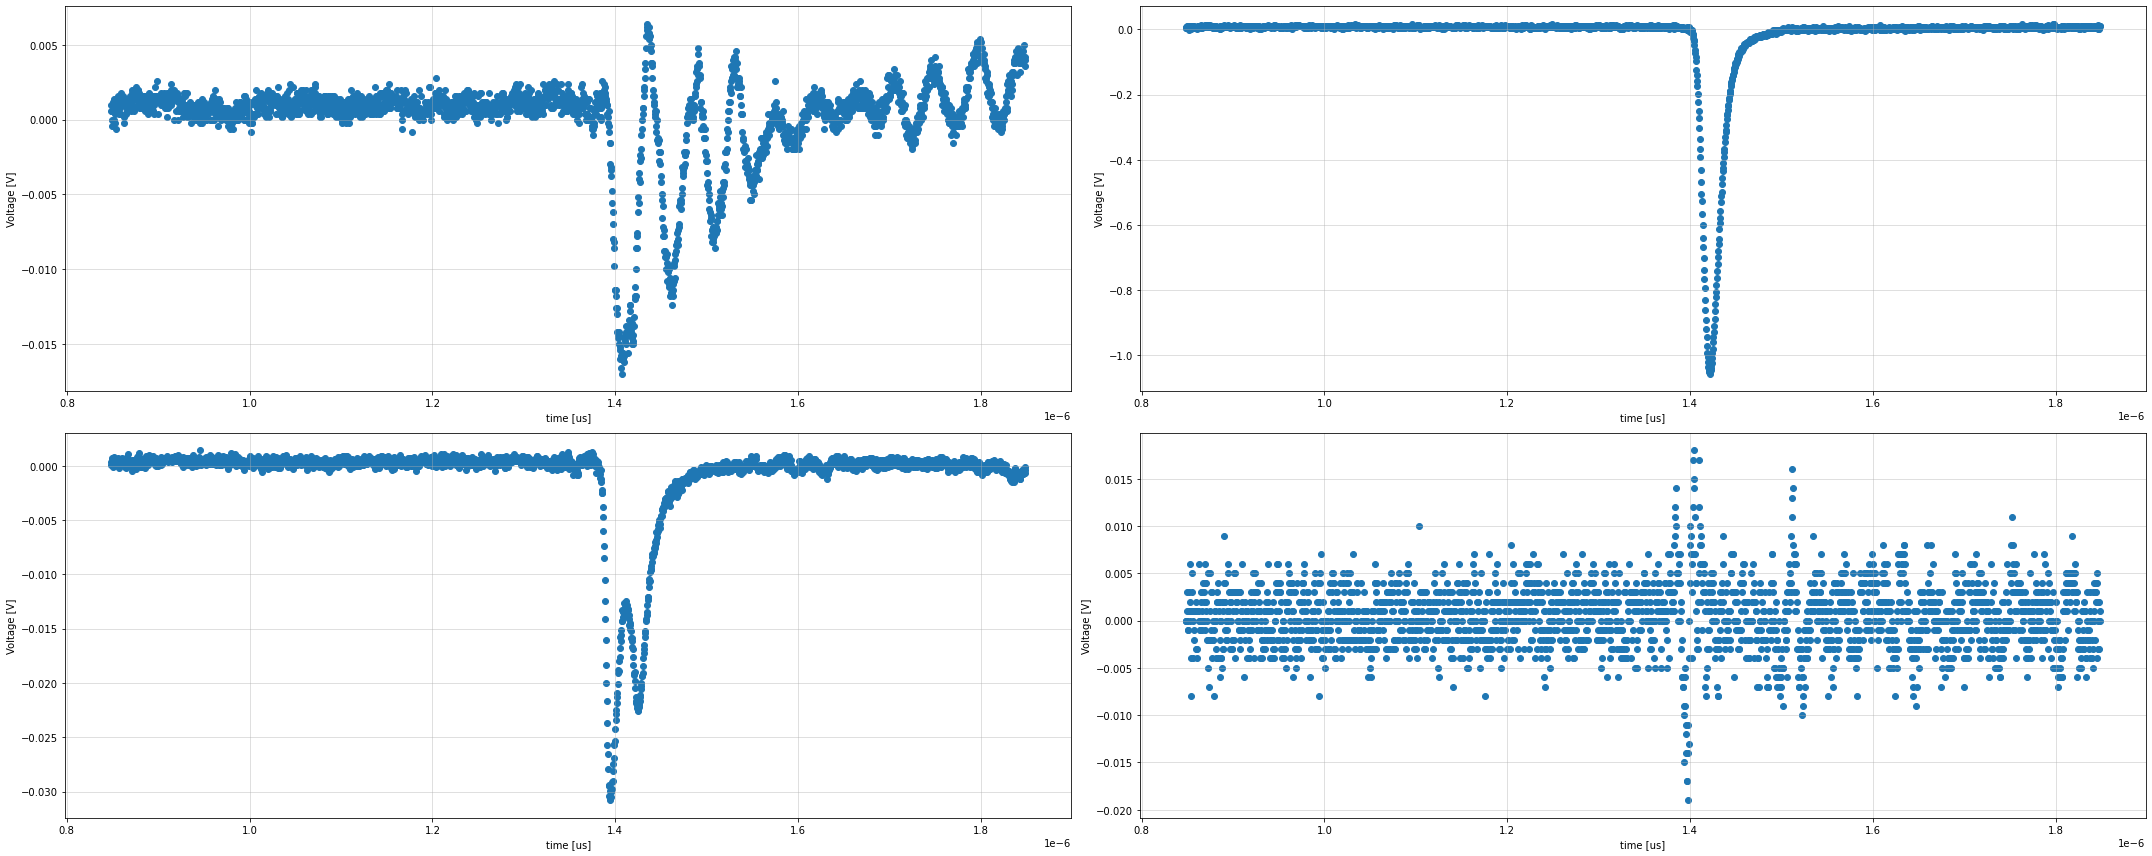

In [4]:
pos = 0

data = Trc().open(fmle[pos])

fig = plt.figure(layout = 'tight', figsize = (30,12))
gs = GridSpec(2, 2, figure = fig)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

for i, ax in enumerate(fig.axes):
    ax.scatter(data[0][i], data[1][i])
    ax.grid(alpha = 0.5)
    ax.set_xlabel(xlabel = 'time [us]')
    ax.set_ylabel(ylabel = 'Voltage [V]')


In [ ]:
print('a')

In [42]:
dfb[dfb.Positron_Waveform != 'None']

,Date,Time,Datetime,run,run_mode,event_number,DAQ,pbar_trap,positron,MCP1,MCP2,MCP3,MCP3.5,MCP4,MCP5,MCP7,Waveform_12bit,CMOS_Tracker,DRS4,Positron_Waveform,SD,LyA,SD_LyA,Cy_Des,NE00_I,NE50_I,NE00_Bm1,NE00_Bm2,NE00_Bm3,NE50_Bm1,NE50_Bm2,Int,Valve_in,MCP_in,MW_power,H-sou_pressure,cube_pressure,RC_pressure,MW_pressure,SwY_pressure,LyA_pressure,Main_delay,PCOs_delay,LyA_delay,Laser_delay,FC_current,MCP4_current,MCP5_current,St_dec_up,St_dec_dw,St_dec_ri,St_dec_le,St_Cub_up,St_Cub_dw,St_Cub_ri,St_Cub_le,St_RC1_up,St_RC1_dw,St_RC1_ri,St_RC1_le,St_RC2_up,St_RC2_dw,St_RC2_ri,St_RC2_le,St_RC3_up,St_RC3_dw,St_RC3_ri,St_RC3_le,St_Al1_up,St_Al1_dw,St_Al1_ri,St_Al1_le,St_Al2_up,St_Al2_dw,St_Al2_ri,St_Al2_le,QT_RC1_+,QT_RC1_-,QT_RC2_+,QT_RC2_-,QT_RC3_+,QT_RC3_-,SwY_1_+,SwY_1_-,SwY_3_+,SwY_3_-,EL_pT_in,EL_pT_1,EL_pT_2,EL_pT_3,EL_pT_4,EL_RC_in,EL_SwY_+,EL_Al1_+,EL_Al2_+,EL_Al3_+,Ly_MCP_1,Ly_MCP_2,Ly_MCP_3,Ly_MCP_4,Qnch_+,Qnch_-,TgDefl_+,H-Defl_+,H-Cor1_-,H-Cor1-,1_phos_+,1_mcp_+,2_phos_+,2_mcp_+,3_phos_+,3_mcp_+,3.5_grid_-,3.5_phos_+,3.5_mcp_+,4_phos_+,4_mcp_+,5_phos_+,5_mcp_+,6_phos_+,6_mcp_+,7_phos_+,7_mcp_+,Sci_1_-,Sci_2_-,H_offs,target_pos,front_bias,mw_amp_curr,hfs_temp,hfs_freq,hfs_pow,sc_temp,sc_freq,sc_pow,empty_1,empty_2,empty_3,empty_4,empty_5,empty_6,empty_7,empty_8
11729,24_07_07,1.720338e+09,2024-07-07 09:47:46.880000,611.0,2.0,302,0.0,0,0,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/PCO-...,None,/eos/experiment/gbar/pgunpc/data/24_07_07/WF12...,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/24_0...,None,None,None,Pbar_2024_NewOptics,10.746,10.905,0.0,0.0,0.0,0.0,0.0,48.951,335580103.0,0.0,7.184020e-08,1.190000e-08,9.270000e-09,2.714000e-09,2.980000e-09,5.660000e-09,1.010000e-09,0.000902,0.001006,0.00101,0.000999,2.565954e-07,1.945068e-07,0.000084,49.95322,-49.99300,9.955977,-9.978592,14.93247,-14.99690,-14.98165,14.95742,-34.99614,34.95148,9.955970,-9.962359,-37.79596,37.93463,-13.79245,13.96145,-59.78622,59.99295,-24.82016,25.03760,0.021126,0.033979,0.029243,0.026210,0.030869,0.017951,0.016888,0.020693,-73.02967,72.71957,-101.0758,100.7238,-133.0403,132.6967,1099.845,-1099.959,599.8528,-599.9332,-1550.001,-3300.004,-2199.984,-1500.002,0.381878,-2049.999,-0.075553,-0.234004,-0.160924,-0.169475,-0.777184,-0.719831,-0.73301,-0.767342,-0.004203,-0.147833,699.8705,-0.054870,-0.763885,-0.763802,0.10218,-0.024289,-0.017718,-0.008724,-0.019117,-0.018276,0.034563,-0.008299,-0.037652,-0.115005,-0.014161,3999.999,2200.000,-0.133705,-0.150243,-0.003631,-0.035572,-940.0068,-940.0087,0.000103,111.0,0.0,0.0,49.6,1.162000e+09,-3.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11730,24_07_07,1.720339e+09,2024-07-07 09:49:45.685000,611.0,2.0,303,0.0,0,0,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/PCO-...,None,/eos/experiment/gbar/pgunpc/data/24_07_07/WF12...,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/24_0...,None,None,None,Pbar_2024_NewOptics,10.615,10.803,0.0,0.0,0.0,0.0,0.0,48.299,335580103.0,0.0,-1.470739e-07,1.200000e-08,9.260000e-09,2.738000e-09,2.980000e-09,5.650000e-09,1.010000e-09,0.000902,0.001006,0.00101,0.000999,2.426074e-07,1.967358e-07,0.000084,49.94970,-49.99360,9.951947,-9.979399,14.92897,-14.99819,-14.98301,14.95366,-34.99599,34.94761,9.952417,-9.963630,-37.79626,37.93476,-13.79385,13.96163,-59.78632,59.99512,-24.82103,25.03881,0.023366,0.035722,0.029491,0.029446,0.033110,0.016707,0.017635,0.020195,-73.03007,72.72028,-101.0736,100.7252,-133.0402,132.6965,1099.845,-1099.958,599.8514,-599.9323,-1549.998,-3299.968,-2199.959,-1499.970,0.515393,-2050.001,-0.075553,-0.238931,-0.160924,-0.167014,-0.777184,-0.719831,-0.73301,-0.767342,-0.004203,-0.147833,699.8709,-0.027659,-0.763885,-0.763802,0.10218,-0.024289,-0.020686,-0.007241,-0.022078,-0.016793,0.069171,-0.002370,-0.039132,-0.116983,-0.014161,3999.997,2199.997,-0.131725,-0.149254,-0.001161,-0.045454,-940.0120,-940.0068,0.000103,111.0,0.0,0.0,49.7,1.162000e+09,-3.0,0.0,0.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11731,24_07

In [43]:
dfb[dfb.run == 611]

,Date,Time,Datetime,run,run_mode,event_number,DAQ,pbar_trap,positron,MCP1,MCP2,MCP3,MCP3.5,MCP4,MCP5,MCP7,Waveform_12bit,CMOS_Tracker,DRS4,Positron_Waveform,SD,LyA,SD_LyA,Cy_Des,NE00_I,NE50_I,NE00_Bm1,NE00_Bm2,NE00_Bm3,NE50_Bm1,NE50_Bm2,Int,Valve_in,MCP_in,MW_power,H-sou_pressure,cube_pressure,RC_pressure,MW_pressure,SwY_pressure,LyA_pressure,Main_delay,PCOs_delay,LyA_delay,Laser_delay,FC_current,MCP4_current,MCP5_current,St_dec_up,St_dec_dw,St_dec_ri,St_dec_le,St_Cub_up,St_Cub_dw,St_Cub_ri,St_Cub_le,St_RC1_up,St_RC1_dw,St_RC1_ri,St_RC1_le,St_RC2_up,St_RC2_dw,St_RC2_ri,St_RC2_le,St_RC3_up,St_RC3_dw,St_RC3_ri,St_RC3_le,St_Al1_up,St_Al1_dw,St_Al1_ri,St_Al1_le,St_Al2_up,St_Al2_dw,St_Al2_ri,St_Al2_le,QT_RC1_+,QT_RC1_-,QT_RC2_+,QT_RC2_-,QT_RC3_+,QT_RC3_-,SwY_1_+,SwY_1_-,SwY_3_+,SwY_3_-,EL_pT_in,EL_pT_1,EL_pT_2,EL_pT_3,EL_pT_4,EL_RC_in,EL_SwY_+,EL_Al1_+,EL_Al2_+,EL_Al3_+,Ly_MCP_1,Ly_MCP_2,Ly_MCP_3,Ly_MCP_4,Qnch_+,Qnch_-,TgDefl_+,H-Defl_+,H-Cor1_-,H-Cor1-,1_phos_+,1_mcp_+,2_phos_+,2_mcp_+,3_phos_+,3_mcp_+,3.5_grid_-,3.5_phos_+,3.5_mcp_+,4_phos_+,4_mcp_+,5_phos_+,5_mcp_+,6_phos_+,6_mcp_+,7_phos_+,7_mcp_+,Sci_1_-,Sci_2_-,H_offs,target_pos,front_bias,mw_amp_curr,hfs_temp,hfs_freq,hfs_pow,sc_temp,sc_freq,sc_pow,empty_1,empty_2,empty_3,empty_4,empty_5,empty_6,empty_7,empty_8
11428,24_07_07,1.720303e+09,2024-07-07 00:01:20.950000,611.0,2.0,1,0.0,0,0,None,None,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/WF12...,None,None,None,None,None,None,Pbar_2024_NewOptics,10.575,10.687,0.0,0.0,0.0,0.0,0.0,47.756,335580103.0,0.0,-4.325703e-07,1.210000e-08,9.160000e-09,2.767000e-09,3.040000e-09,5.610000e-09,1.010000e-09,0.000902,0.001006,0.00101,0.000999,2.526797e-07,2.009119e-07,0.000082,49.95284,-49.99543,9.955755,-9.980725,14.93278,-14.99933,-14.98434,14.95837,-34.99845,34.95155,9.956366,-9.965024,-37.78965,37.94401,-13.78493,13.97006,-59.77563,60.00453,-24.81211,25.04860,0.019632,0.033730,0.027002,0.026708,0.030869,0.014716,0.016888,0.019697,-73.03081,72.71915,-101.0741,100.7228,-133.0407,132.6959,1099.846,-1099.961,599.8519,-599.9326,-1549.998,-3300.000,-2199.999,-1499.999,0.374461,-2050.007,-0.075553,-0.221685,-0.158462,-0.167014,-0.777184,-0.719831,-0.73301,-0.767342,-0.004203,-0.147833,699.8707,-0.040028,-0.763885,-0.763802,0.10218,-0.024289,-0.019202,-0.007241,-0.016155,-0.013826,0.084003,-0.006817,-0.039132,-0.118960,-0.014161,3999.998,2200.000,-0.134695,-0.142330,-0.020916,-0.060276,-940.0053,-940.0034,0.000103,111.0,0.0,0.0,49.9,1.162000e+09,-3.0,49.8,910000000.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11429,24_07_07,1.720303e+09,2024-07-07 00:03:14.951000,611.0,2.0,2,0.0,0,0,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data/24_07_07/PCO-...,None,/eos/experiment/gbar/pgunpc/data/24_07_07/WF12...,None,None,None,None,None,None,Pbar_2024_NewOptics,10.639,10.793,0.0,0.0,0.0,0.0,0.0,48.316,335580103.0,0.0,-1.654325e-07,1.200000e-08,9.130000e-09,2.772000e-09,3.050000e-09,5.640000e-09,1.010000e-09,0.000902,0.001006,0.00101,0.000999,2.546368e-07,1.897735e-07,0.000083,49.95296,-49.99482,9.955699,-9.979516,14.93308,-14.99805,-14.98306,14.95822,-34.99633,34.95202,9.956091,-9.963717,-37.78760,37.94529,-13.78255,13.97143,-59.77462,60.00819,-24.80867,25.05303,0.022868,0.034975,0.029989,0.030940,0.033608,0.017702,0.020621,0.021937,-73.02839,72.72200,-101.0731,100.7225,-133.0374,132.6978,1099.847,-1099.958,599.8552,-599.9311,-1549.998,-3299.999,-2200.004,-1500.001,0.352208,-2049.998,-0.075553,-0.226613,-0.156000,-0.167014,-0.777184,-0.719831,-0.73301,-0.767342,-0.004203,-0.147833,699.8721,-0.062291,-0.763885,-0.763802,0.10218,-0.024289,-0.013267,-0.007241,-0.023559,-0.016793,0.064227,-0.005335,-0.040611,-0.124891,-0.014161,3999.999,2199.998,-0.147566,-0.144308,0.008716,-0.035572,-939.9993,-940.0010,0.000103,111.0,0.0,0.0,49.9,1.162000e+09,-3.0,49.8,910000000.0,-100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11430,24_07_07,1.720304e+09,2024-07-07 00:05:15.675000,611.0,2.0,3,0.0,0,0,None,None,None,None,None,/eos/experiment/gbar/pgunpc/data